In [72]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph
from adjustText import adjust_text
from scipy.stats import mode, zscore, median_abs_deviation
import joblib
# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score, make_scorer, recall_score, f1_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)


In [73]:
# Load Data
data = pd.read_csv("Data_Raw.csv", header=1)
sites = data['site']
niki = pd.read_csv("Data_Niki.csv")
niki = niki.drop(index=[0,1])
niki['Engineer classification.1'] = (niki['Engineer classification.1'] == 'Release').astype(int)
y = niki['Engineer classification.1']

# Dropping Unnecessary Rows and Columns
filtered_ordered_columns = [col for col in niki['Parameter name'] if col in data.columns]
data = data[filtered_ordered_columns]
data = pd.concat([sites, data], axis=1)
data = data.apply(pd.to_numeric, errors='coerce') 

# Obtaining Median and Std for Each Site and Each Parameter
med = data.groupby('site').median()
std = data.groupby('site').std()

# med = med.fillna(0)
# std = std.fillna(0)

med = med.T.copy()
std = std.T.copy()

C:\Users\nxg15046\AppData\Local\Temp\1\ipykernel_20900\3059869606.py:4: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [74]:
# Standardizing by Row
z_med = med.apply(zscore, axis=1, nan_policy='omit')
z_med = pd.DataFrame(z_med.tolist(), index=med.index, columns=med.columns)
z_std = std.apply(zscore, axis=1, nan_policy='omit')
z_std = pd.DataFrame(z_std.tolist(), index=std.index, columns=std.columns)

# Range (need to remove lower and upper limit)
z_med_min = z_med.min(axis=1)
z_std_min = z_std.min(axis=1)
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
z_med_range = z_med_max - z_med_min
z_std_range = z_std_max - z_std_min

## Inter-Quartile Range
Q1_med = z_med.quantile(0.25, axis=1)
Q3_med = z_med.quantile(0.75, axis=1)
z_med_iqr = Q3_med - Q1_med
Q1_std = z_std.quantile(0.25, axis=1)
Q3_std = z_med.quantile(0.75, axis=1)
z_std_iqr = Q3_std - Q1_std

## Median Absolute Deviation
z_med_mad = z_med.apply(median_abs_deviation, axis=1)
z_std_mad = z_std.apply(median_abs_deviation, axis=1)

## Skewness
med_skewness = med.skew(axis=1)
std_skewness = std.skew(axis=1)

## Kurtosis (Propensity for Outliers)
med_kurtosis = med.kurt(axis=1)
std_kurtosis = std.kurt(axis=1)

In [75]:
# Concatenating All Features
y.index = z_med.index
x = pd.concat([z_med_range, z_std_range, z_med_iqr, z_std_iqr, z_med_mad, z_std_mad, med_skewness, std_skewness, med_kurtosis, std_kurtosis, y], axis=1)

# Assigning New Column Names to Bypass Column Name Repeating Issue
num_columns = x.shape[1]
x.columns = x.columns.astype(str)
new_columns = ["z_med_range", "z_std_range", "z_med_iqr", "z_std_iqr", "z_med_mad", "z_std_mad", "med_skewness", "std_skewness", "med_kurtosis", "std_kurtosis", "y"]
x.columns = new_columns

corr_matrix = x.corr(numeric_only=True)
print(corr_matrix["y"].sort_values(ascending=False))
x = x.drop('y', axis=1)

y               1.000000
z_med_mad       0.651143
z_med_iqr       0.560460
med_skewness    0.424884
z_std_iqr       0.396754
z_std_mad       0.229869
std_kurtosis   -0.081305
std_skewness   -0.150456
z_std_range    -0.165742
z_med_range    -0.689467
med_kurtosis   -0.743451
Name: y, dtype: float64


c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


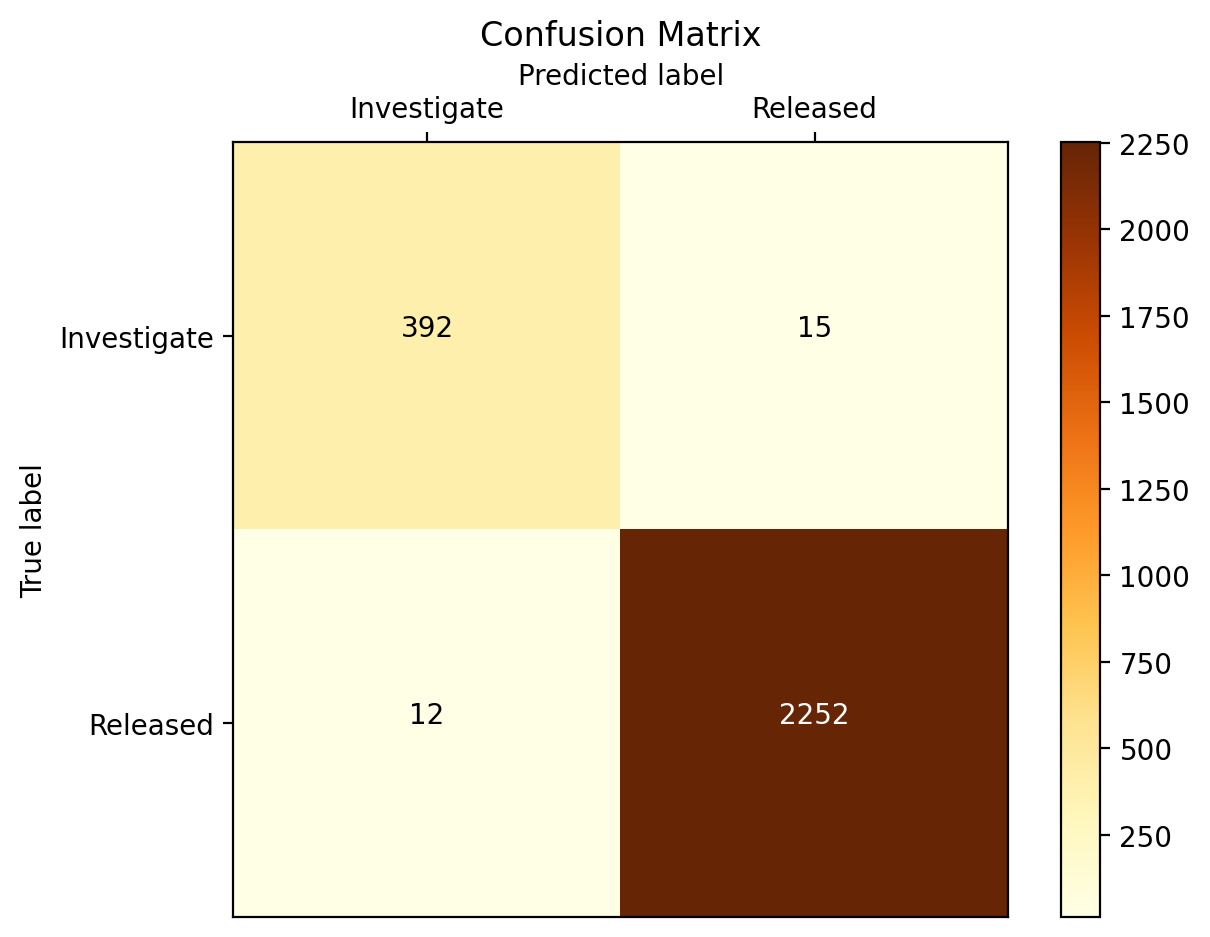

In [92]:
# LGBM Model Trained with No Imputation
raw_loaded = joblib.load('lgbm_raw_noimpute.pkl')
pipeline_impute = joblib.load('pipeline_noimpute.pkl')

x_transformed = pipeline_impute.transform(x)
predictions = raw_loaded.predict(x_transformed)

"""
accuracy = metrics.accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label=0)
recall = recall_score(y, predictions, pos_label=0)
f1 = f1_score(y, predictions, pos_label=0)

print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))
"""
draw_confusion_matrix(y, predictions, ['Investigate', 'Released'])


In [77]:
# Load ground truth data for sites
data_raw = pd.read_csv("Data_Raw.csv", header=1)
niki = pd.read_csv("Data_Niki.csv")
niki = niki.drop(index=[0, 1])

# Extract site names and ground truth classifications
ground_truth_labels = niki['Engineer classification'].values

# Create a dictionary mapping each test parameter index to its problematic sites
ground_truth_dict = {}
for idx, label in enumerate(ground_truth_labels):
    if isinstance(label, str):
        # Split the string of site names into a list
        sites = [s.strip() for s in label.split(',') if s.strip()]
        ground_truth_dict[idx + 4] = sites  # Offset by 4 to match anomalies_dict index
    else:
        ground_truth_dict[idx + 4] = []

C:\Users\nxg15046\AppData\Local\Temp\1\ipykernel_20900\2979726766.py:3: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [78]:
# Keeping "Investigate" Rows
df = pd.DataFrame({'LightGBM': predictions})
df = df[df['LightGBM'] == 0]

# Rename rows for Convenience
new_rows = [i for i in range(z_med.shape[0])]
z_med.index = new_rows
z_std.index = new_rows

# Only Keep Rows to Investigate
z_med = z_med.loc[df.index]
z_std = z_std.loc[df.index]

# For Easier Comparison
offset = 4
df = df.index + offset
z_med.index = z_med.index + offset
z_std.index = z_std.index + offset

# Rename columns
new_columns = [i+1 for i in range(z_med.shape[1])]
z_med.columns = new_columns
z_std.columns = new_columns

full_data = pd.concat([z_med, z_std], axis=1)

In [81]:
# Assuming z_med and z_std are already defined and aligned
# Create a dictionary to store anomalies for each test parameter
anomalies_dict = {}

# Iterate over each test parameter (row)
for idx in z_med.index:
    # Extract median and std for the current test parameter
    param_med = z_med.loc[idx]
    param_std = z_std.loc[idx]

    # Combine into a DataFrame
    data = pd.DataFrame({'med': param_med, 'std': param_std})

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.0065, random_state=42)
    data['anomaly'] = iso_forest.fit_predict(data[['med', 'std']])

    # Get anomalous site names
    anomalies = data[data['anomaly'] == -1].index.tolist()

    # Store in dictionary
    anomalies_dict[idx] = anomalies

# Output the dictionary of anomalies
anomalies_dict

{4: [44, 52],
 7: [90, 136],
 13: [115, 142],
 14: [115, 142],
 15: [2, 77],
 16: [74, 77],
 19: [52, 77],
 24: [96, 179],
 25: [2, 77],
 26: [21, 96],
 27: [2, 77],
 28: [52, 77],
 40: [44, 97],
 44: [44, 158],
 45: [44, 158],
 46: [44, 158],
 47: [44, 158],
 48: [44, 158],
 49: [44, 158],
 50: [44, 158],
 51: [44, 158],
 52: [44, 158],
 53: [44, 158],
 54: [44, 158],
 55: [44, 158],
 56: [44, 158],
 57: [44, 158],
 58: [44, 158],
 59: [44, 158],
 60: [44, 158],
 61: [44, 158],
 62: [44, 158],
 63: [44, 158],
 64: [44, 158],
 65: [44, 158],
 66: [44, 158],
 67: [44, 158],
 68: [44, 158],
 69: [44, 158],
 70: [44, 158],
 71: [44, 158],
 72: [44, 158],
 73: [44, 158],
 74: [20, 44],
 75: [44, 158],
 76: [36, 44],
 77: [44, 134],
 78: [44, 158],
 79: [36, 44],
 80: [44, 158],
 81: [44, 158],
 82: [44, 158],
 83: [44, 158],
 84: [20, 44],
 85: [44, 158],
 86: [44, 158],
 87: [44, 100],
 88: [44, 158],
 89: [44, 158],
 90: [44, 158],
 91: [44, 158],
 92: [44, 134],
 93: [44, 158],
 94: [44

In [82]:
# Compare anomalies_dict with ground_truth_dict
comparison_summary = {}
for test_param, predicted_anomalies in anomalies_dict.items():
    true_anomalies = ground_truth_dict.get(test_param, [])

    # ✅ Fix: Convert both lists to strings for consistent comparison
    predicted_anomalies = [str(x) for x in predicted_anomalies]
    true_anomalies = [str(x) for x in true_anomalies]

    matched = list(set(predicted_anomalies) & set(true_anomalies))
    missed = list(set(true_anomalies) - set(predicted_anomalies))
    false_positives = list(set(predicted_anomalies) - set(true_anomalies))

    comparison_summary[test_param] = {
        'matched': matched,
        'missed': missed,
        'false_positives': false_positives
    }
comparison_summary

{4: {'matched': ['44'], 'missed': [], 'false_positives': ['52']},
 7: {'matched': [], 'missed': [], 'false_positives': ['136', '90']},
 13: {'matched': [], 'missed': [], 'false_positives': ['115', '142']},
 14: {'matched': [], 'missed': [], 'false_positives': ['115', '142']},
 15: {'matched': ['77'], 'missed': [], 'false_positives': ['2']},
 16: {'matched': ['77'], 'missed': [], 'false_positives': ['74']},
 19: {'matched': ['52', '77'], 'missed': [], 'false_positives': []},
 24: {'matched': ['96'], 'missed': [], 'false_positives': ['179']},
 25: {'matched': ['77'], 'missed': [], 'false_positives': ['2']},
 26: {'matched': ['96'], 'missed': [], 'false_positives': ['21']},
 27: {'matched': ['77'], 'missed': [], 'false_positives': ['2']},
 28: {'matched': ['52', '77'], 'missed': [], 'false_positives': []},
 40: {'matched': ['44'], 'missed': [], 'false_positives': ['97']},
 44: {'matched': ['44'], 'missed': [], 'false_positives': ['158']},
 45: {'matched': ['44'], 'missed': [], 'false_posi

In [89]:
# Get position and dictionary key for every entry in comparison_summary
all_indices = [(i, key) for i, key in enumerate(comparison_summary)]

# Print the result
print("Zero-based position and corresponding dictionary key for all entries:")
for position, key in all_indices:
    print(f"Position: {position}, Dictionary Key: {key}")

Zero-based position and corresponding dictionary key for all entries:
Position: 0, Dictionary Key: 4
Position: 1, Dictionary Key: 7
Position: 2, Dictionary Key: 13
Position: 3, Dictionary Key: 14
Position: 4, Dictionary Key: 15
Position: 5, Dictionary Key: 16
Position: 6, Dictionary Key: 19
Position: 7, Dictionary Key: 24
Position: 8, Dictionary Key: 25
Position: 9, Dictionary Key: 26
Position: 10, Dictionary Key: 27
Position: 11, Dictionary Key: 28
Position: 12, Dictionary Key: 40
Position: 13, Dictionary Key: 44
Position: 14, Dictionary Key: 45
Position: 15, Dictionary Key: 46
Position: 16, Dictionary Key: 47
Position: 17, Dictionary Key: 48
Position: 18, Dictionary Key: 49
Position: 19, Dictionary Key: 50
Position: 20, Dictionary Key: 51
Position: 21, Dictionary Key: 52
Position: 22, Dictionary Key: 53
Position: 23, Dictionary Key: 54
Position: 24, Dictionary Key: 55
Position: 25, Dictionary Key: 56
Position: 26, Dictionary Key: 57
Position: 27, Dictionary Key: 58
Position: 28, Dict

In [83]:
# Identifying all non-empty 'missed' entries and their actual positions
indices_with_missed = [(i, key) for i, key in enumerate(comparison_summary) if comparison_summary[key]['missed']]

# Print the result
print("Zero-based position and corresponding dictionary key where 'missed' is not empty:")
for position, key in indices_with_missed:
    print(f"Position: {position}, Dictionary Key: {key}")

Zero-based position and corresponding dictionary key where 'missed' is not empty:
Position: 102, Dictionary Key: 179
Position: 104, Dictionary Key: 183
Position: 106, Dictionary Key: 187
Position: 236, Dictionary Key: 371
Position: 305, Dictionary Key: 865
Position: 374, Dictionary Key: 2469
Position: 378, Dictionary Key: 2495
Position: 382, Dictionary Key: 2519
Position: 386, Dictionary Key: 2534
Position: 388, Dictionary Key: 2536
Position: 389, Dictionary Key: 2538


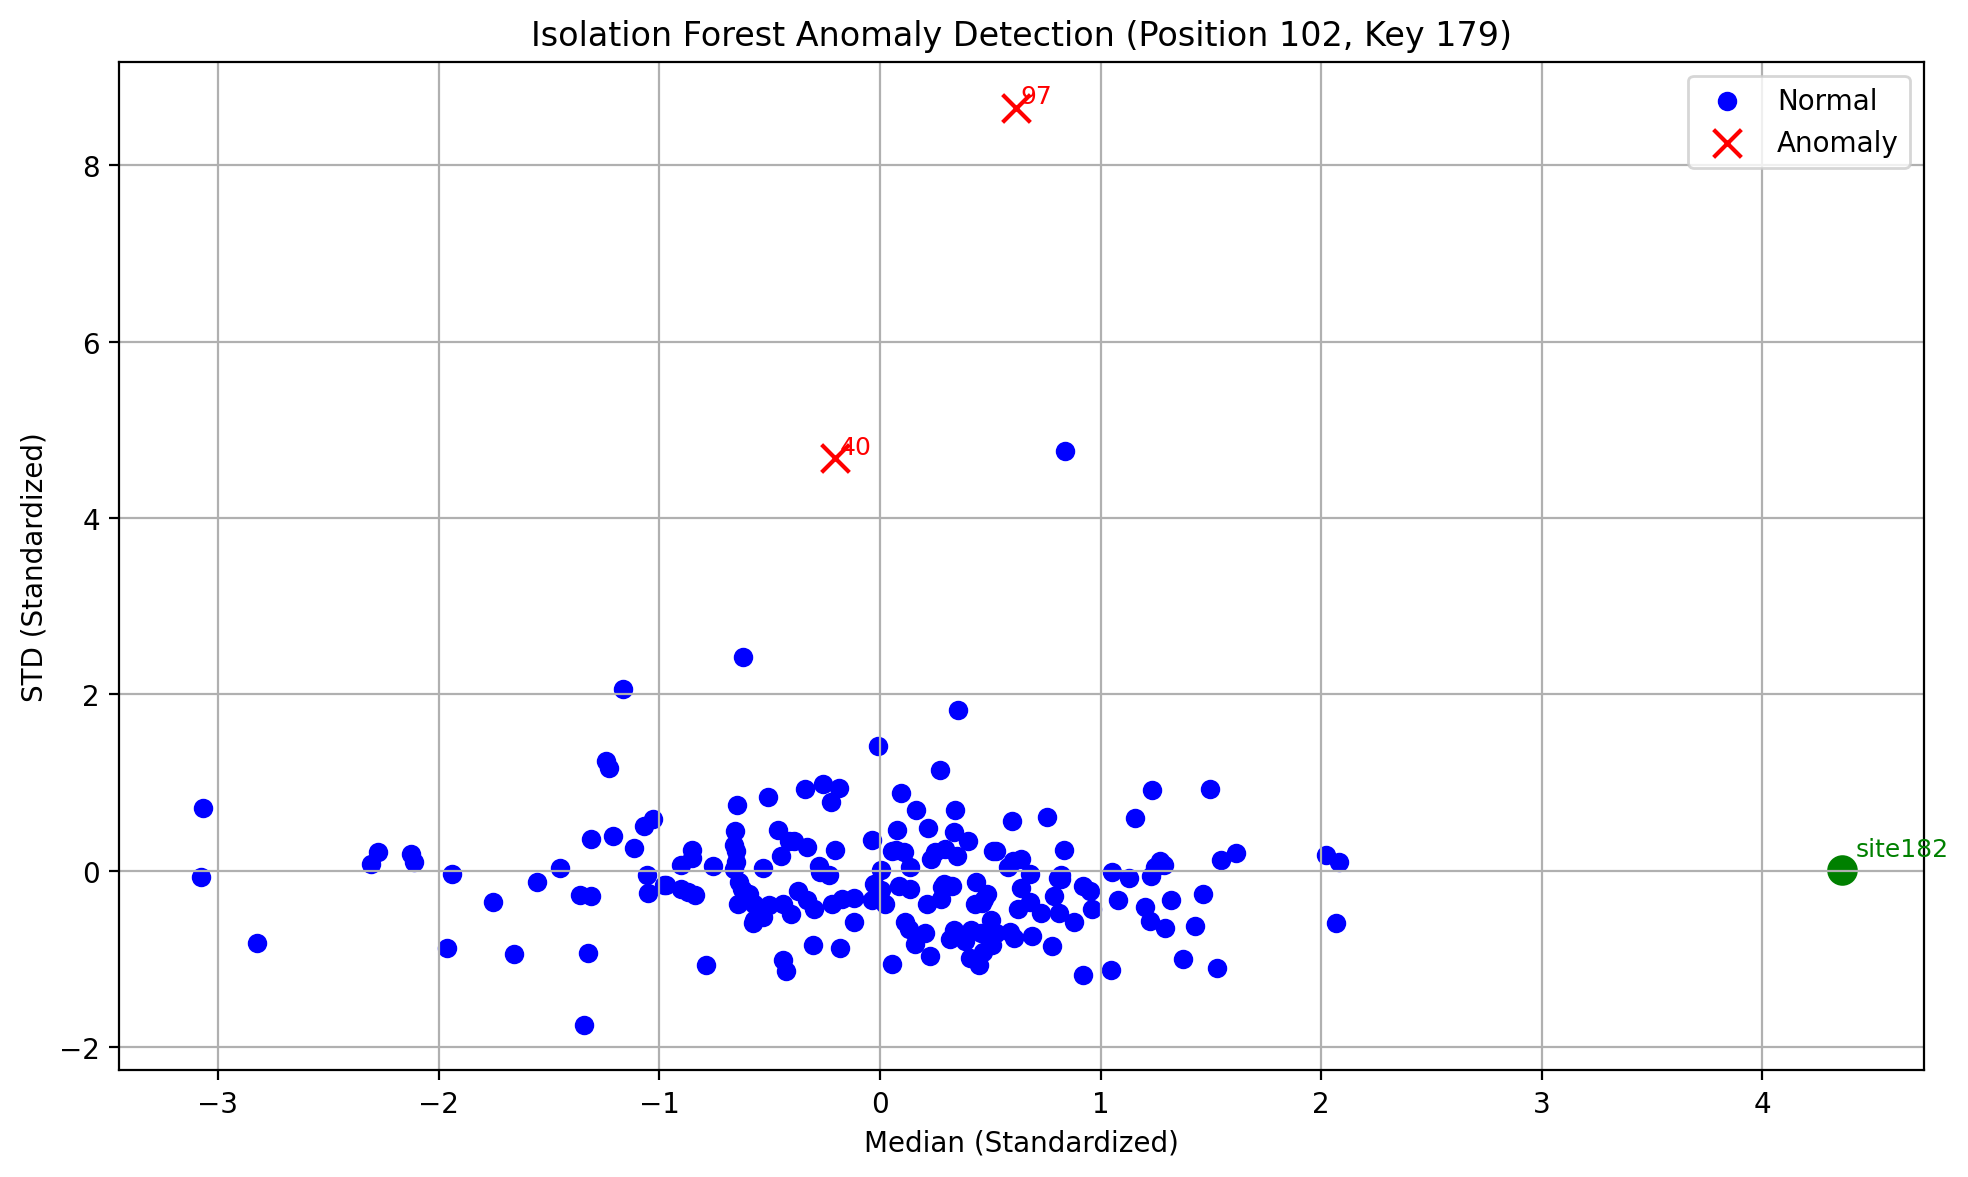

Anomalous sites detected for Position 102, Key 179:
[40, 97]


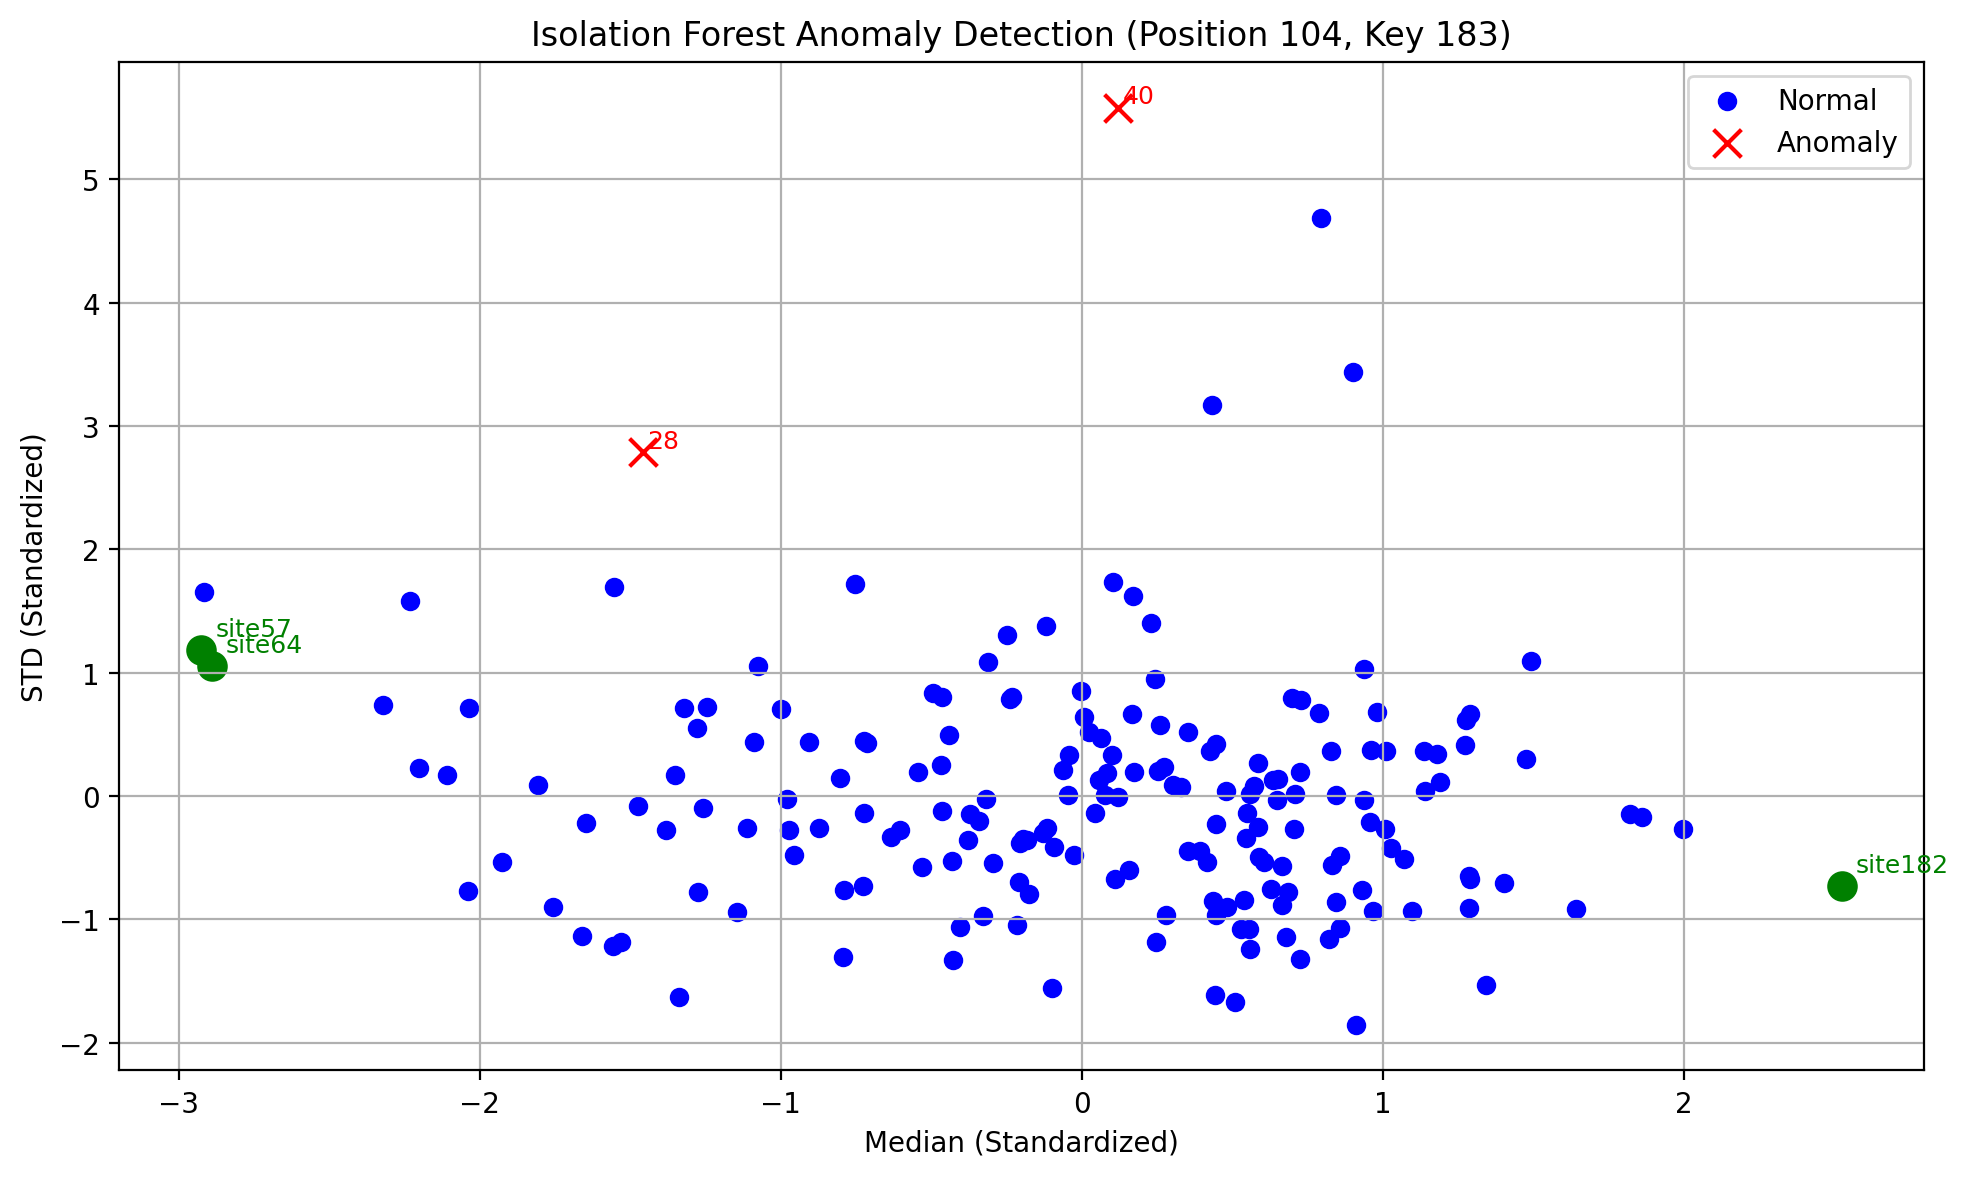

Anomalous sites detected for Position 104, Key 183:
[28, 40]


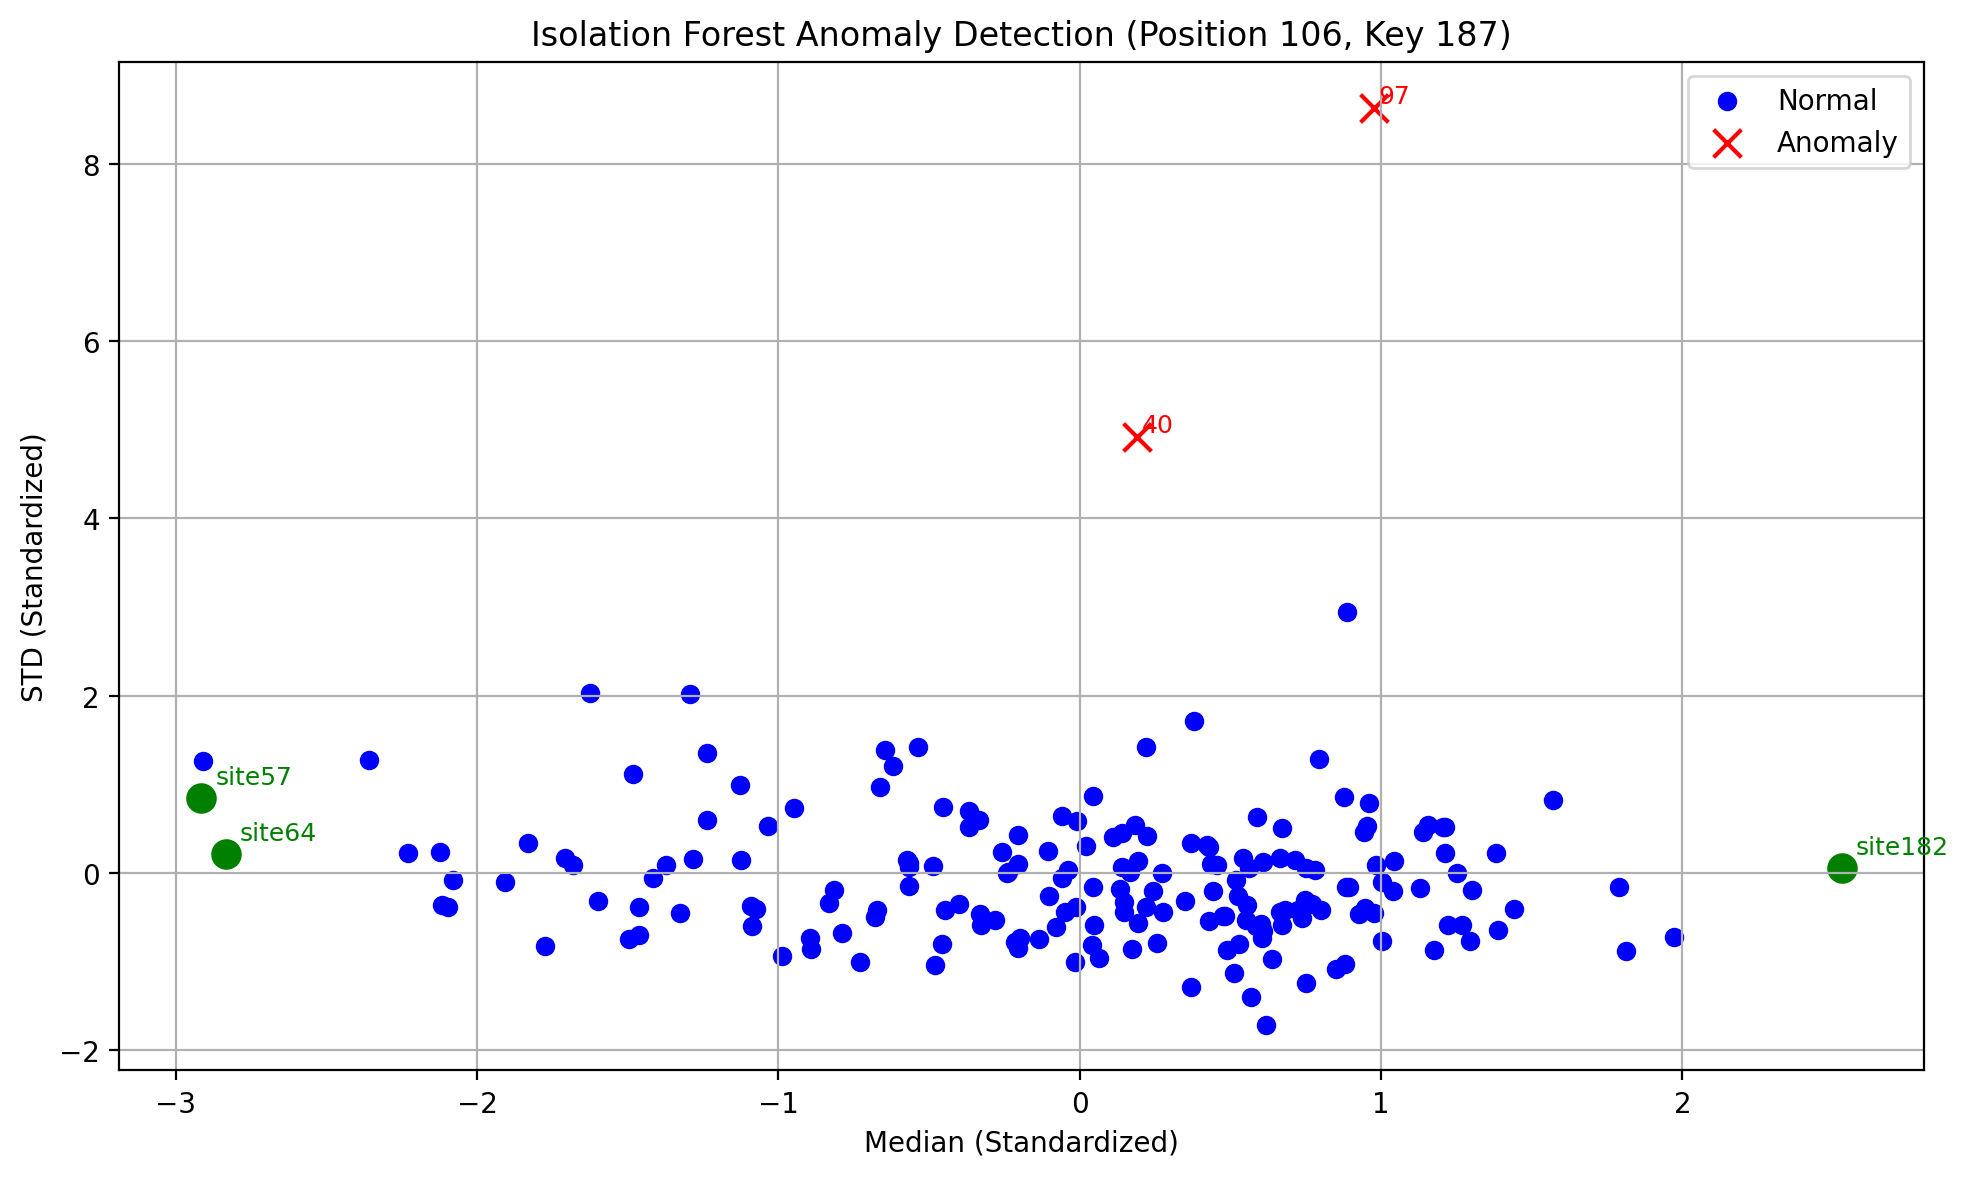

Anomalous sites detected for Position 106, Key 187:
[40, 97]


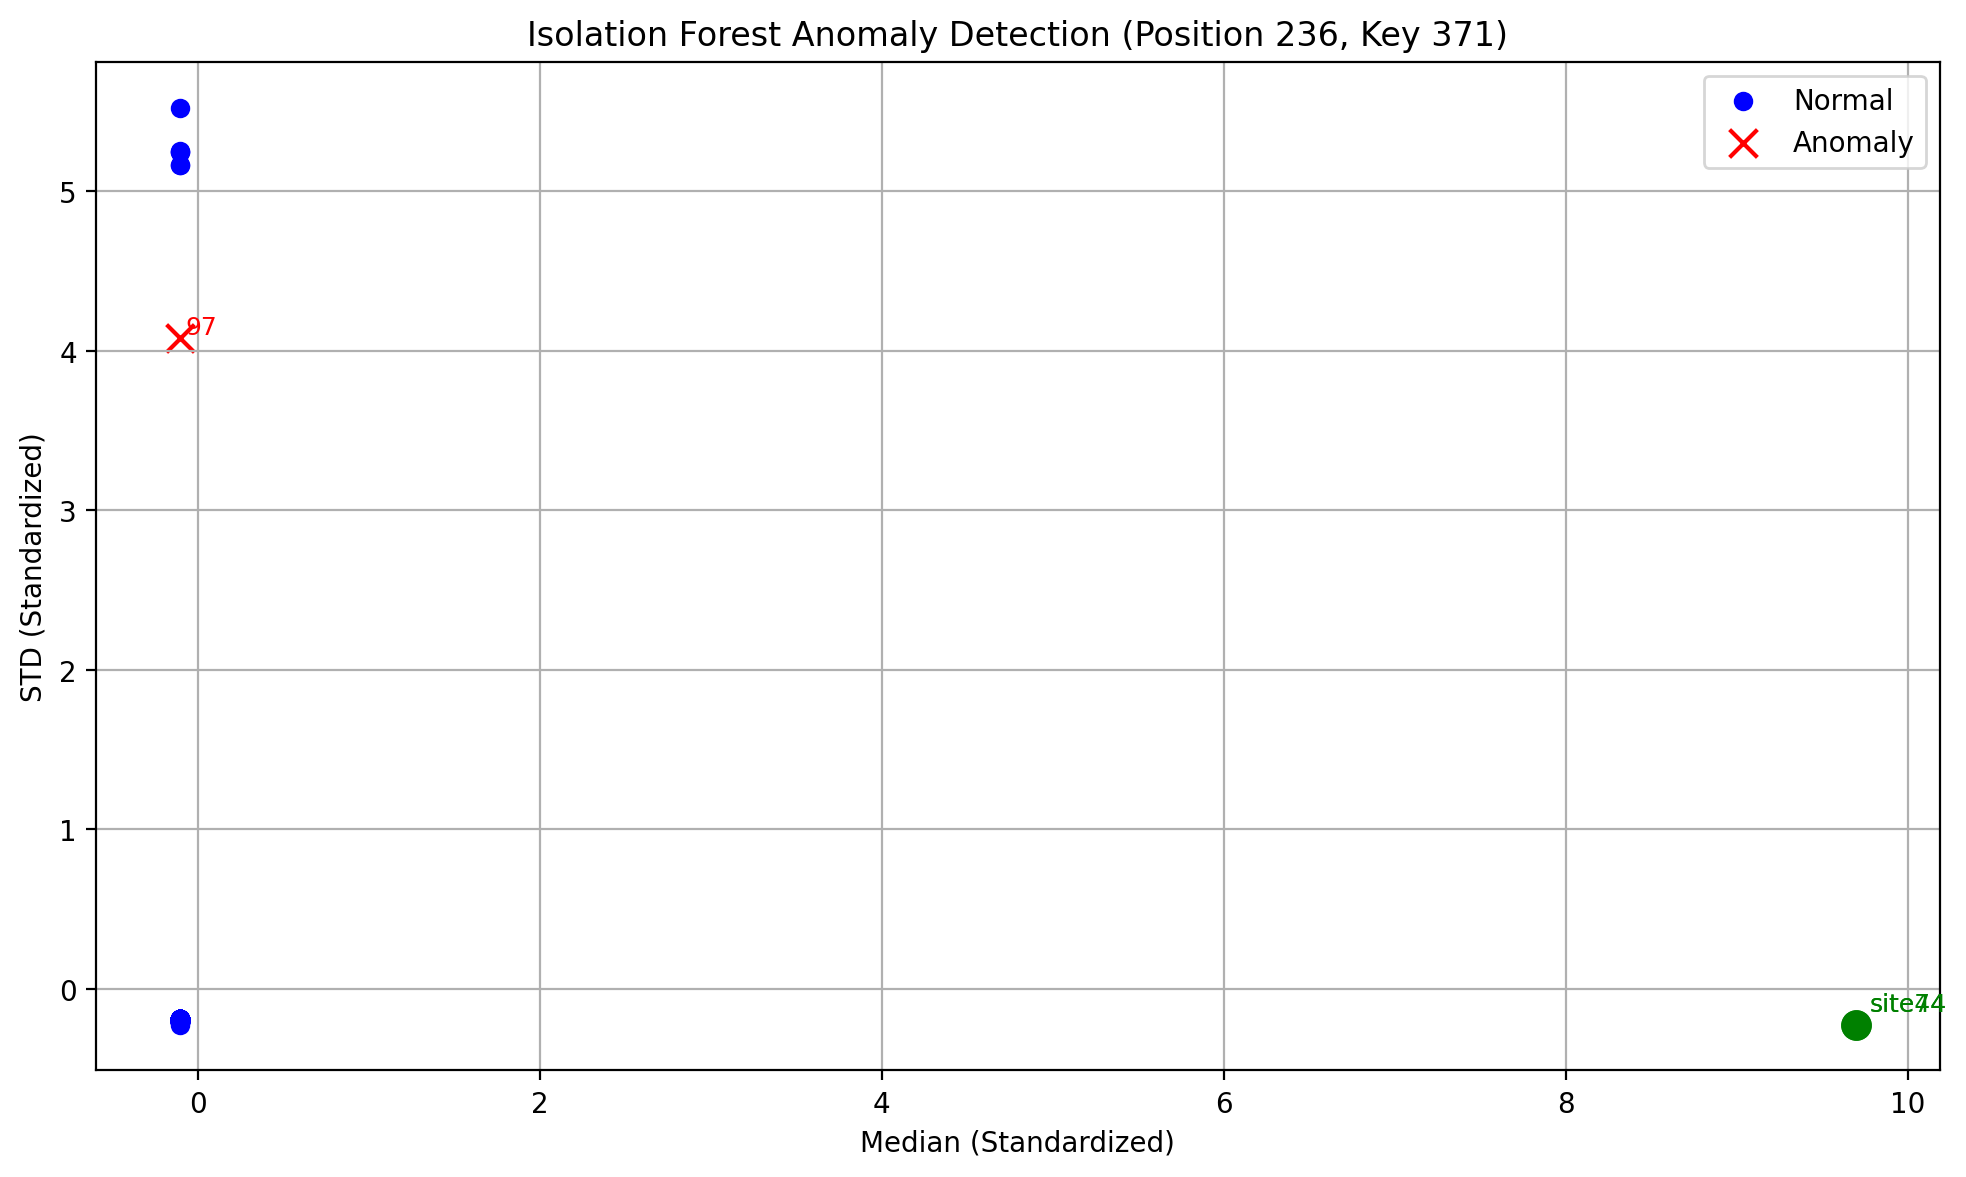

Anomalous sites detected for Position 236, Key 371:
[97]


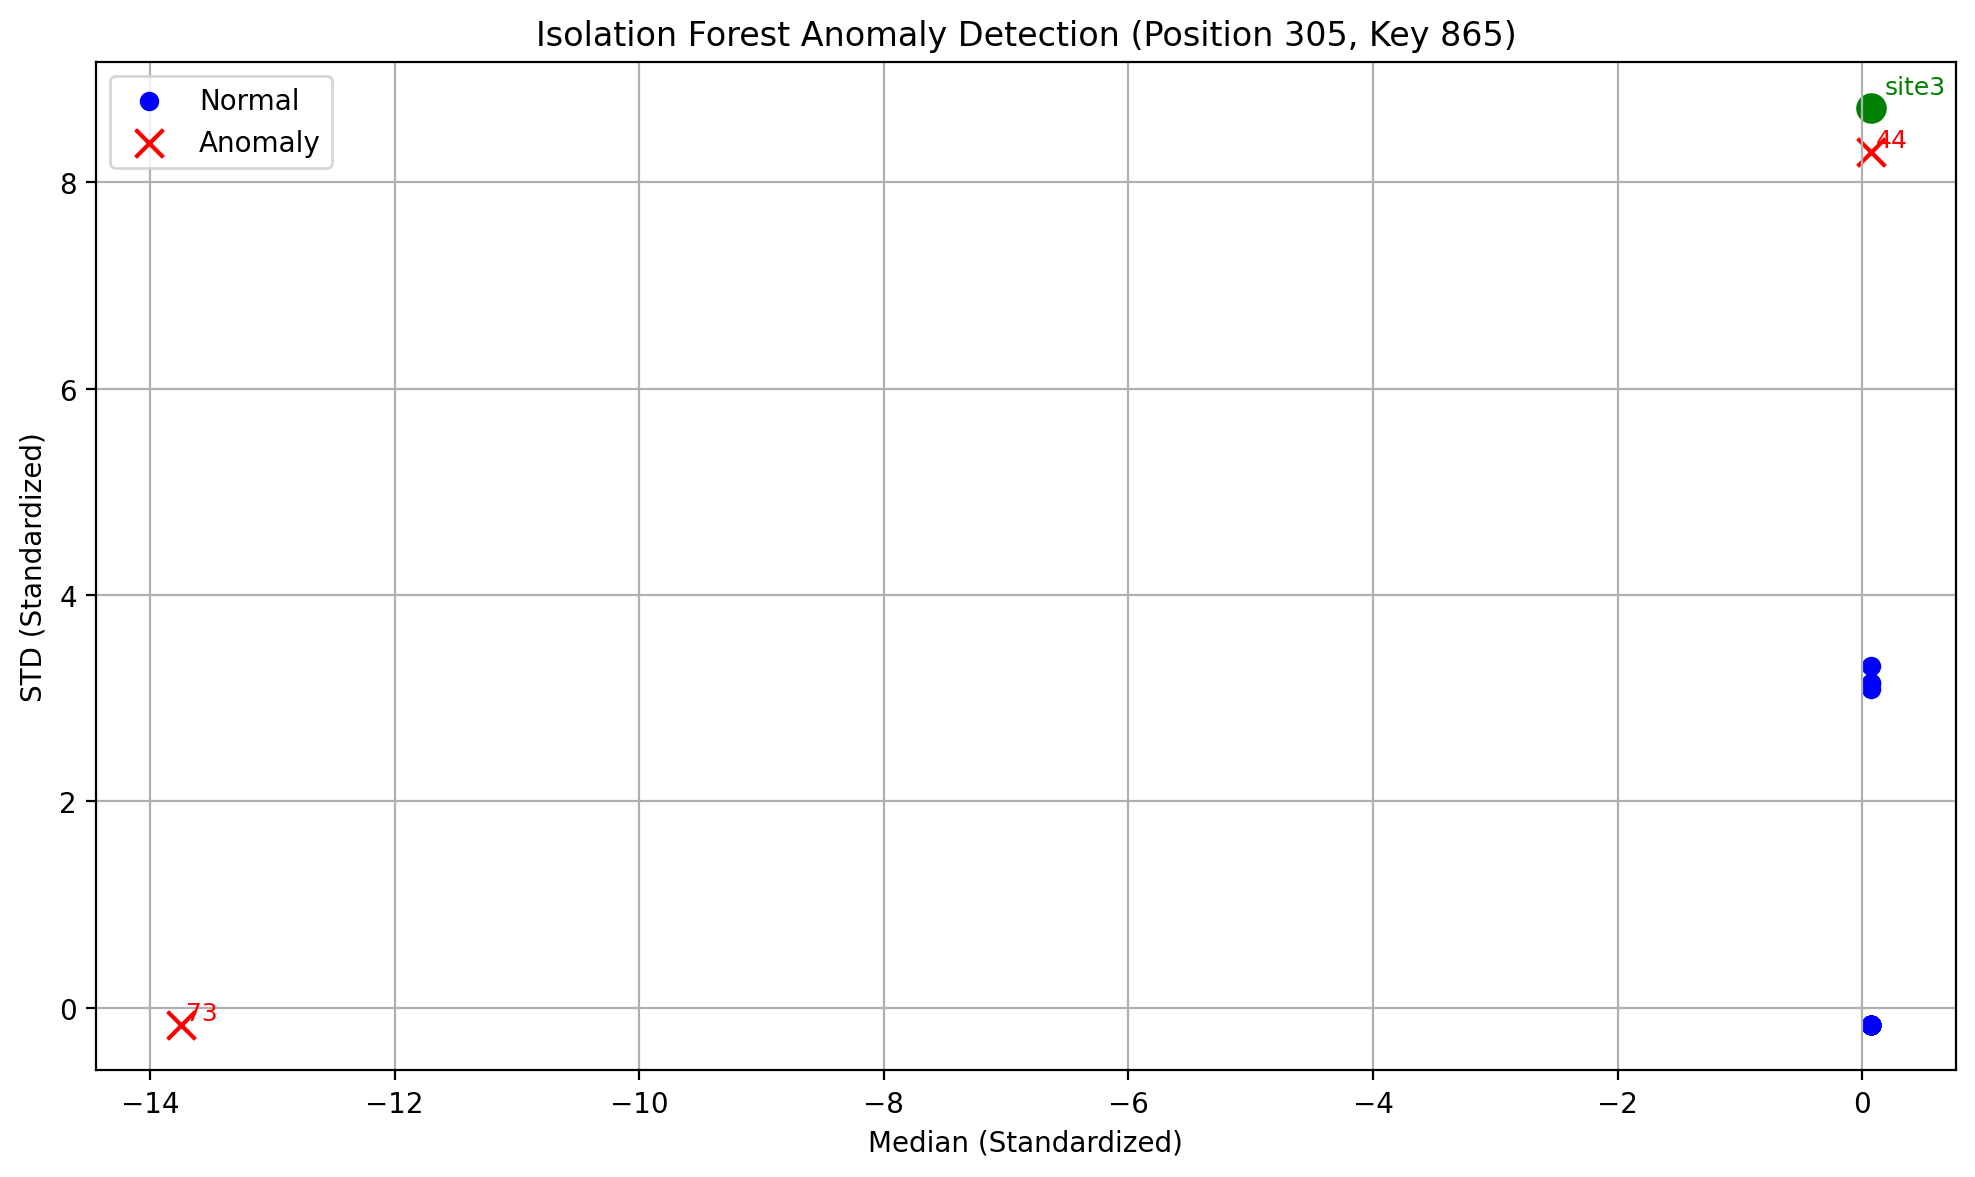

Anomalous sites detected for Position 305, Key 865:
[44, 73]


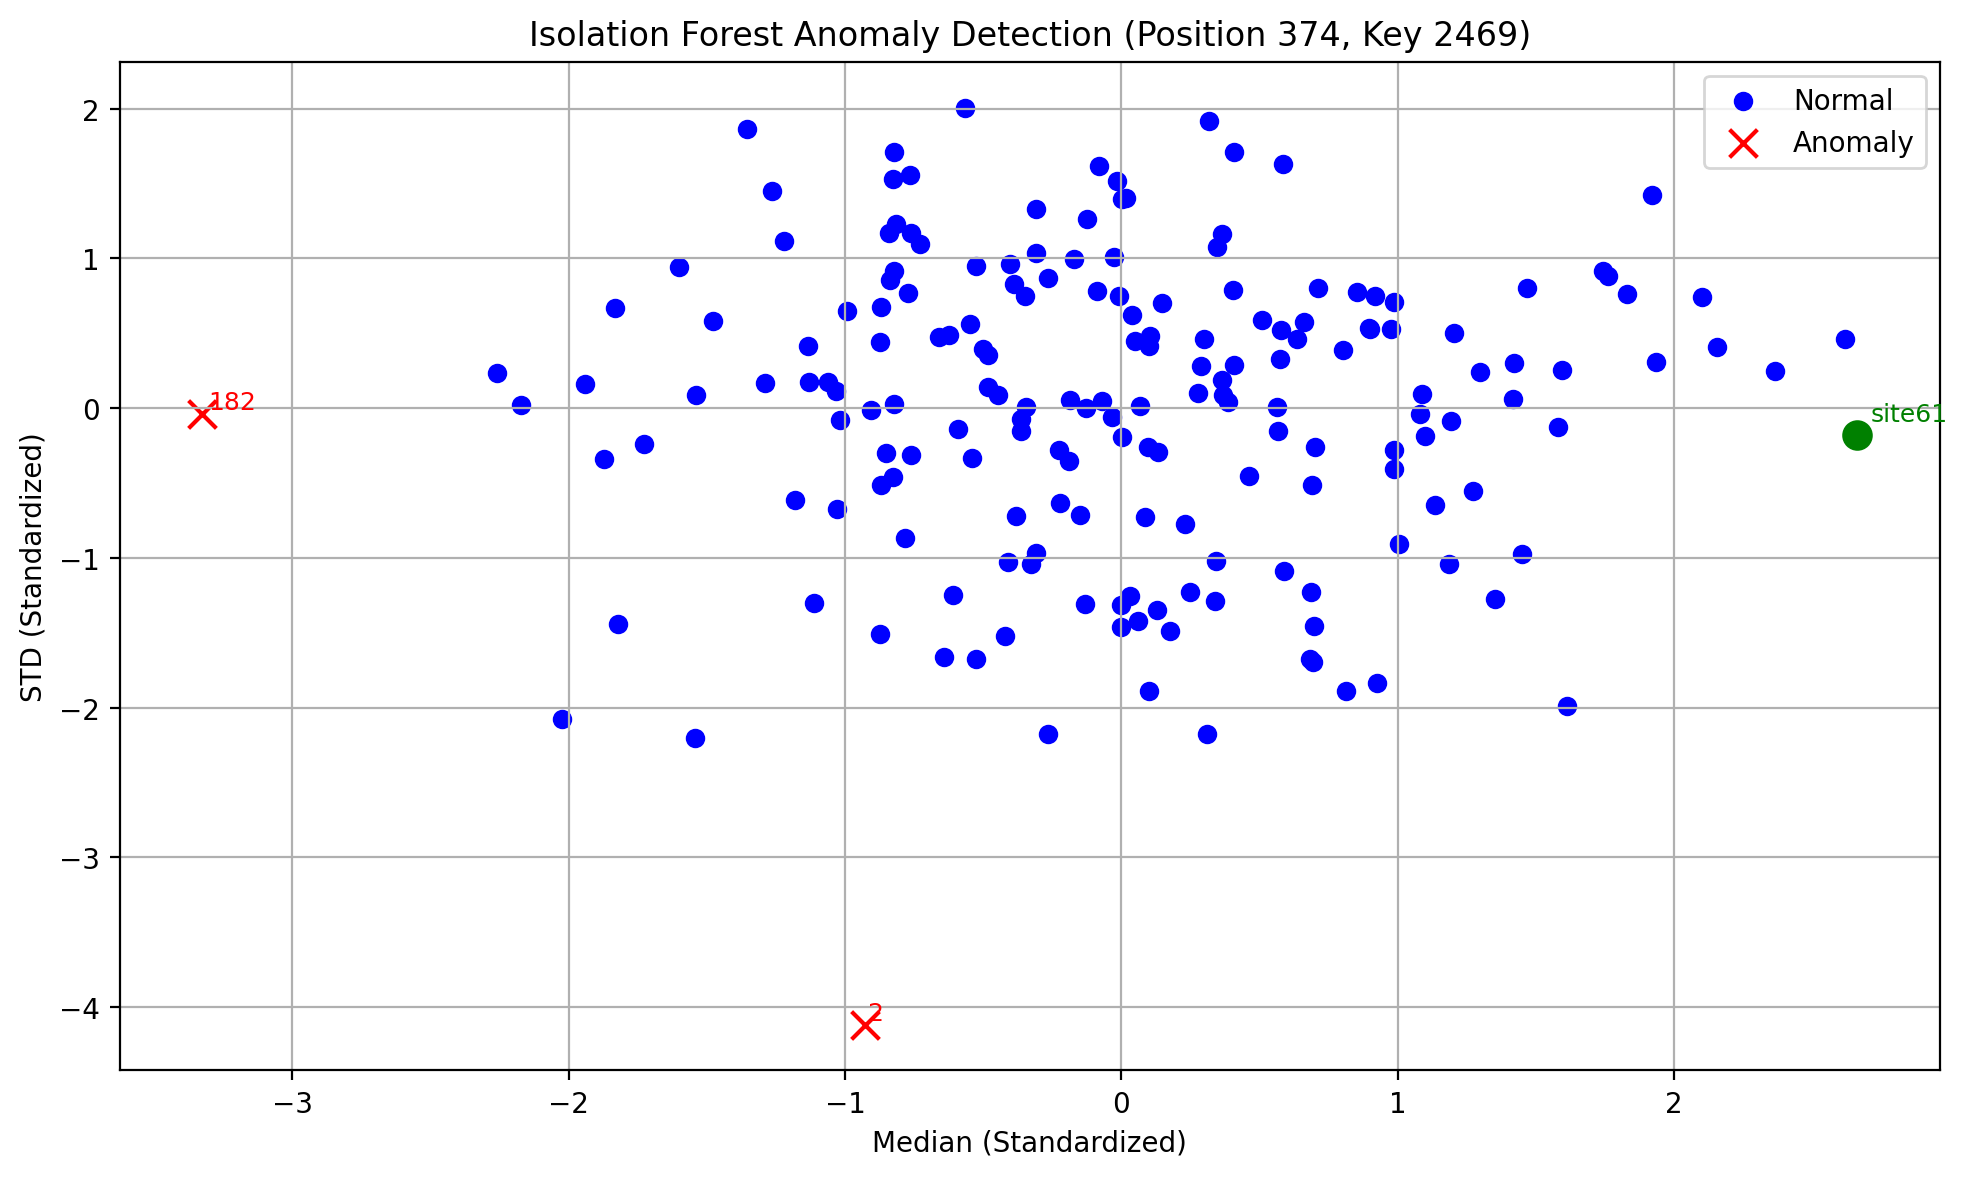

Anomalous sites detected for Position 374, Key 2469:
[2, 182]


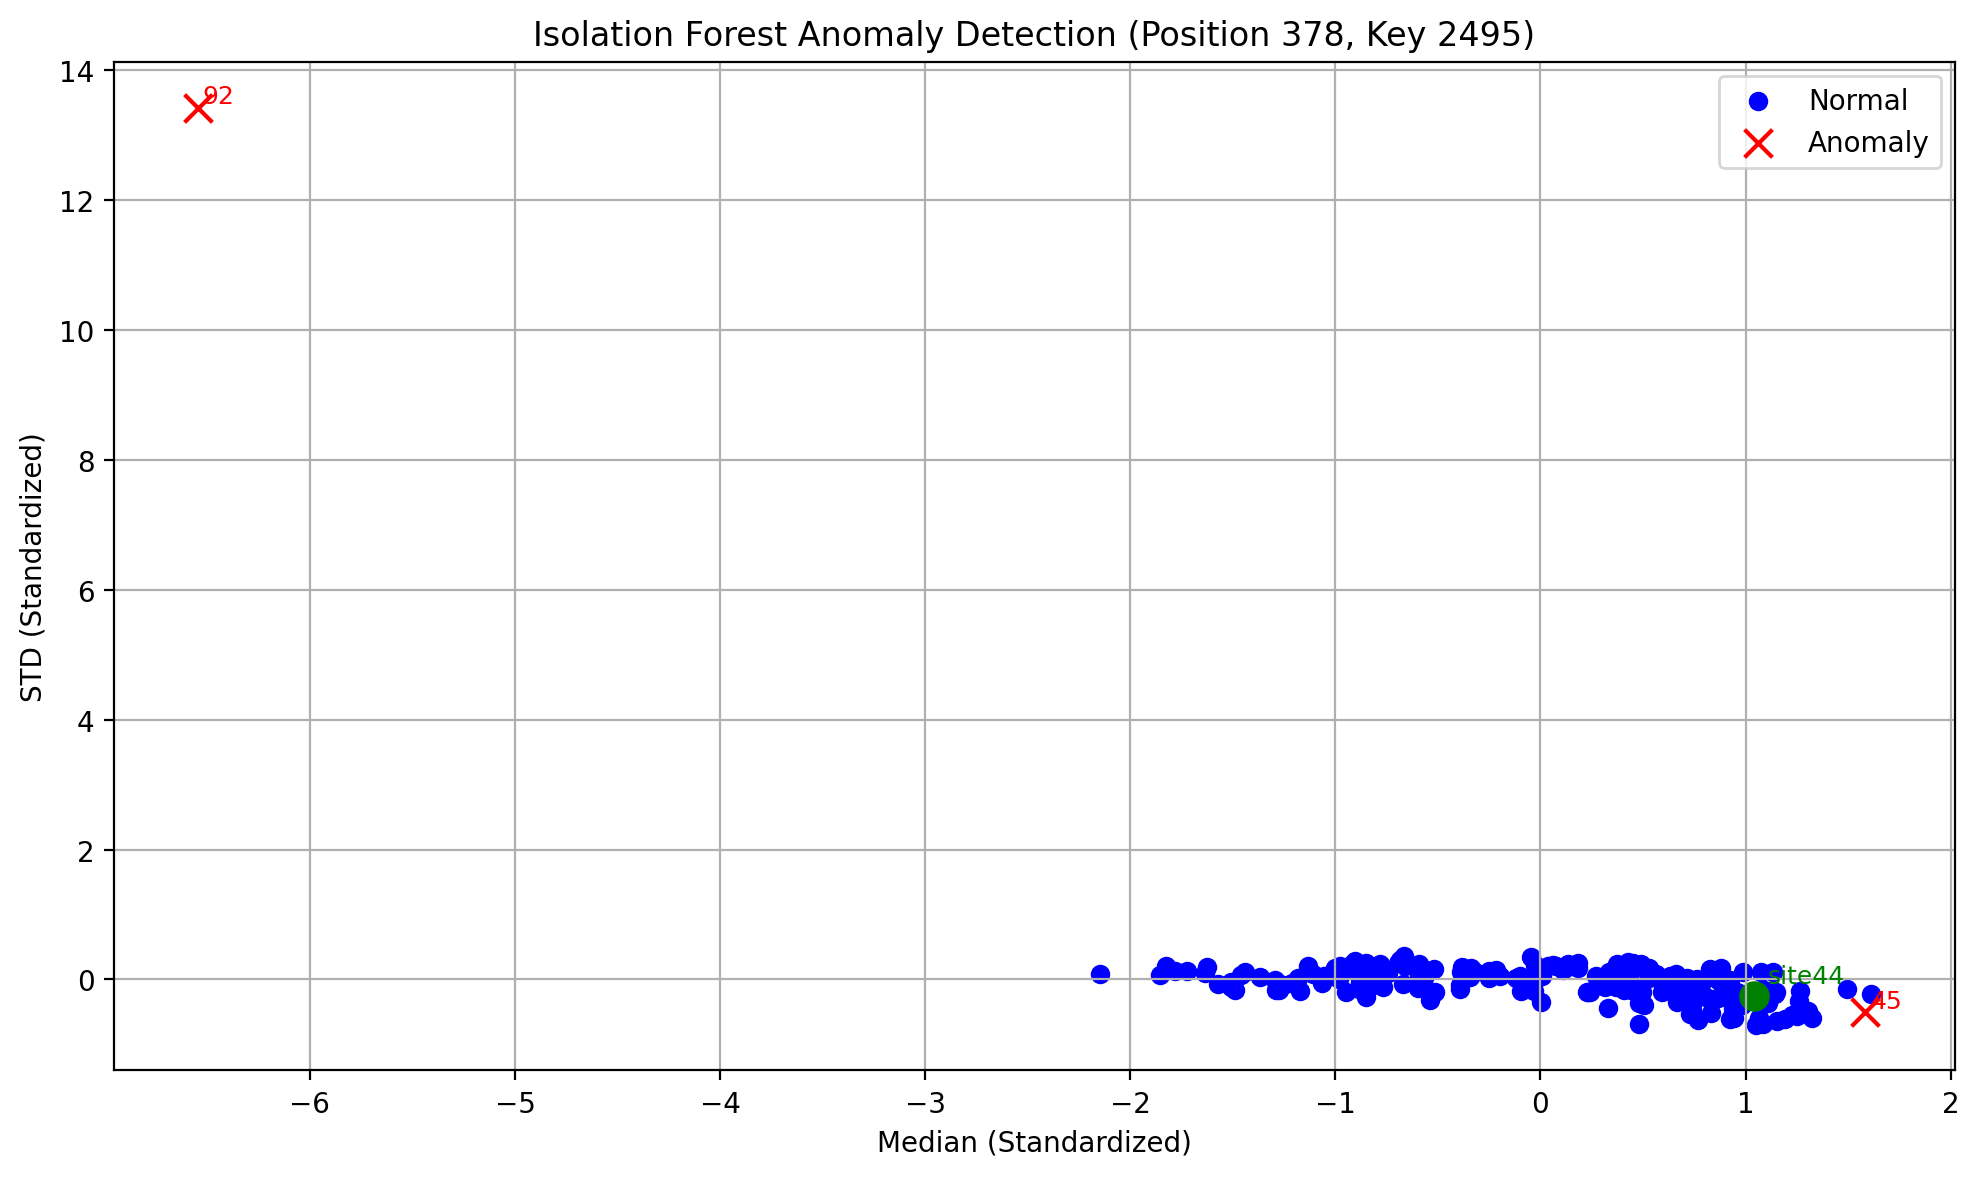

Anomalous sites detected for Position 378, Key 2495:
[45, 92]


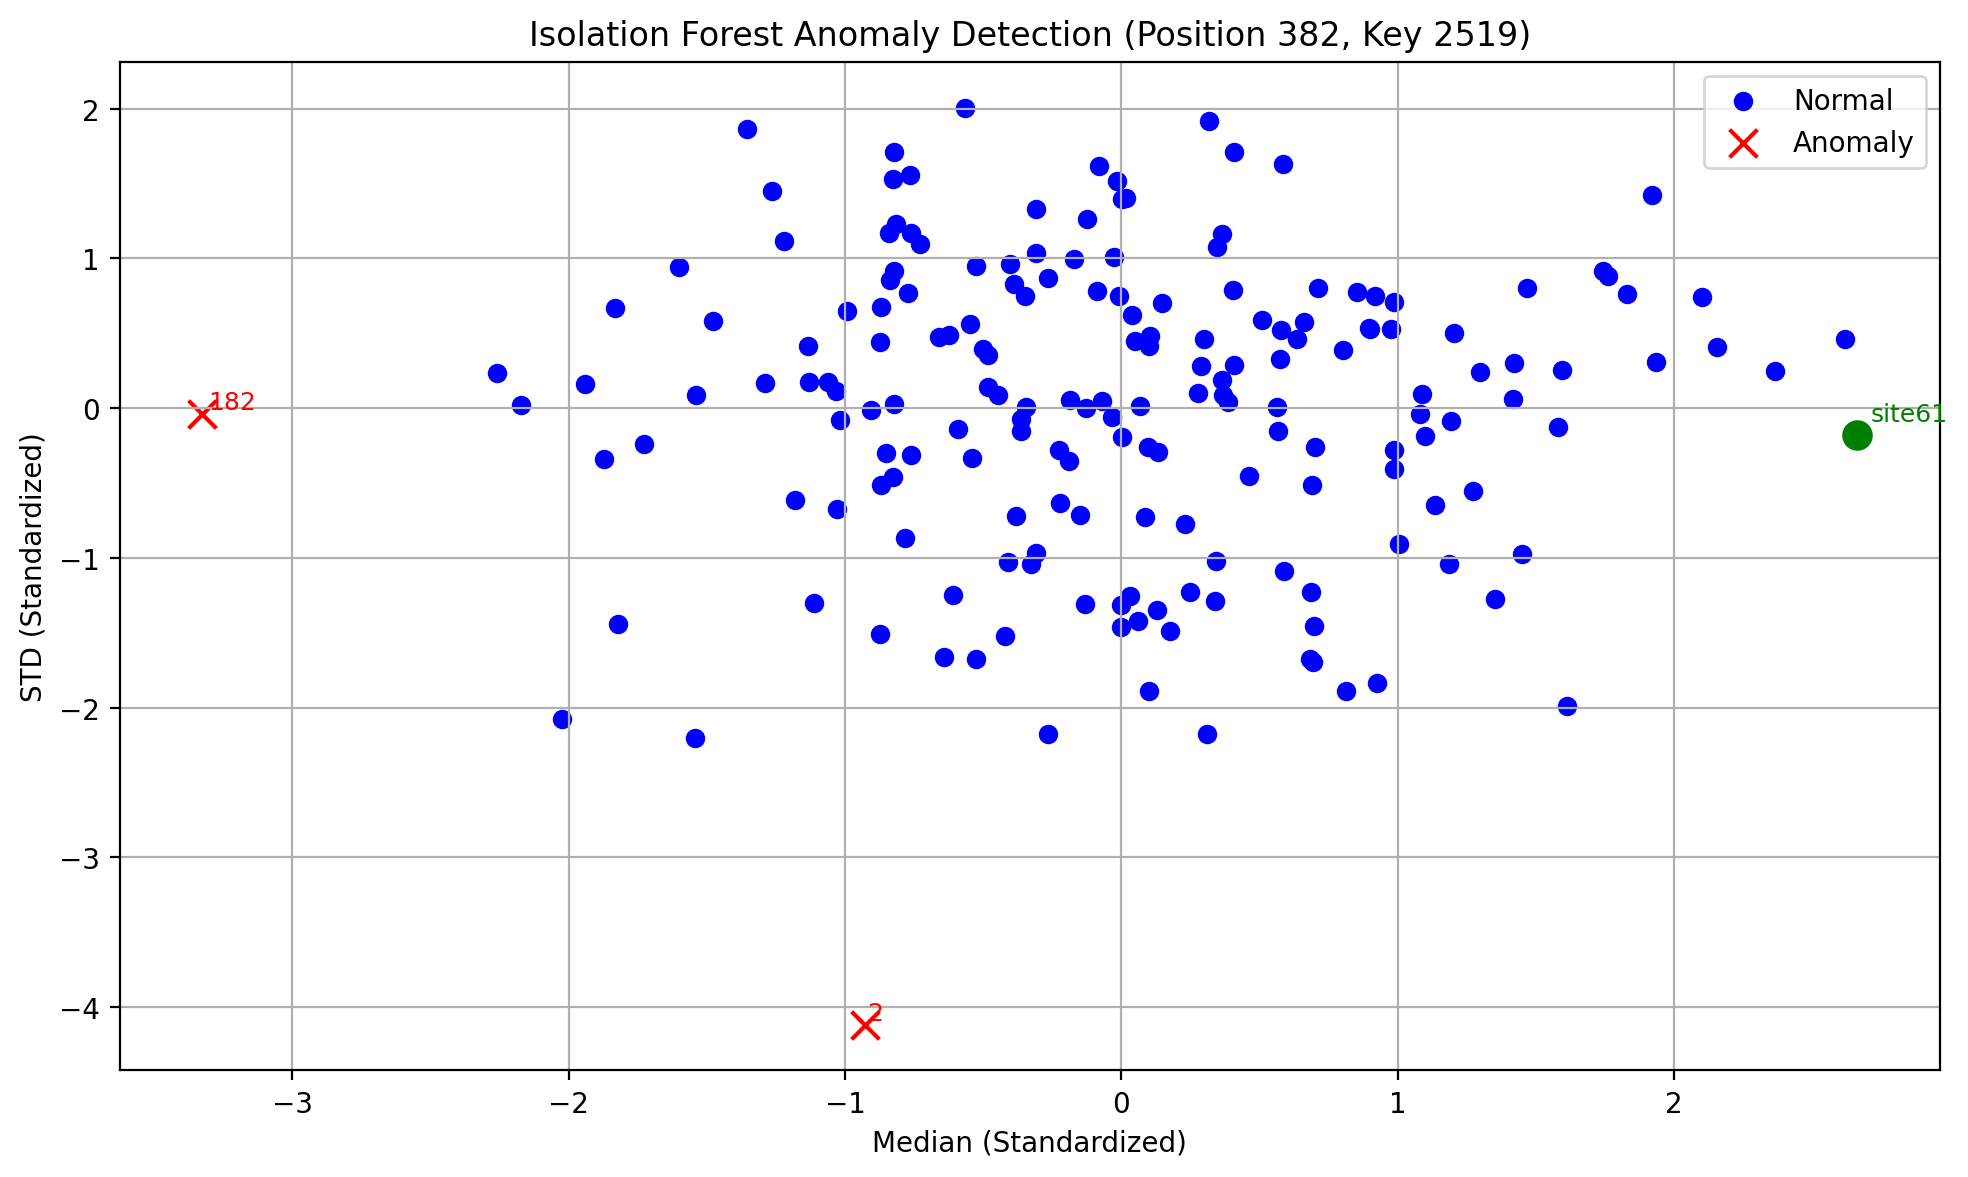

Anomalous sites detected for Position 382, Key 2519:
[2, 182]


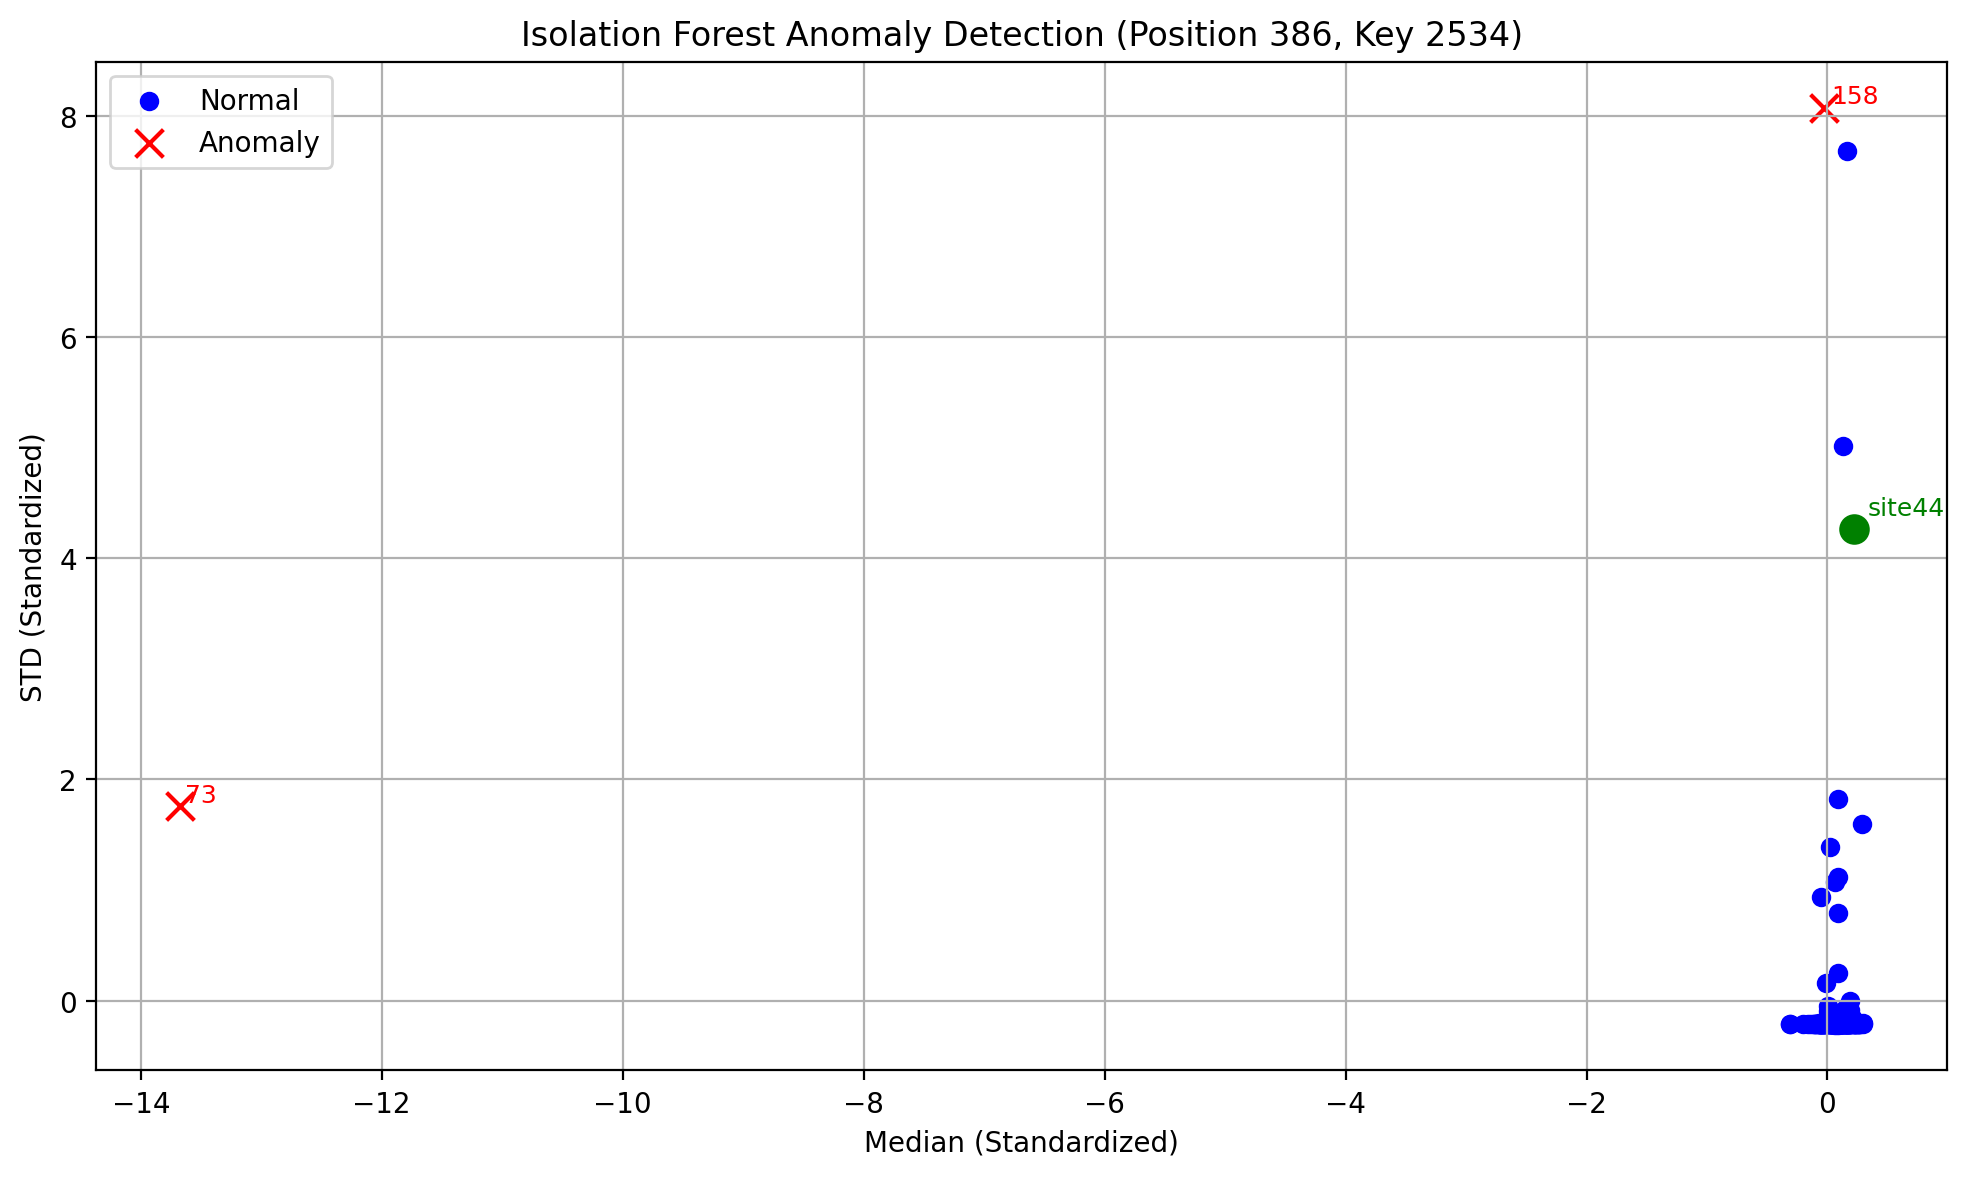

Anomalous sites detected for Position 386, Key 2534:
[73, 158]


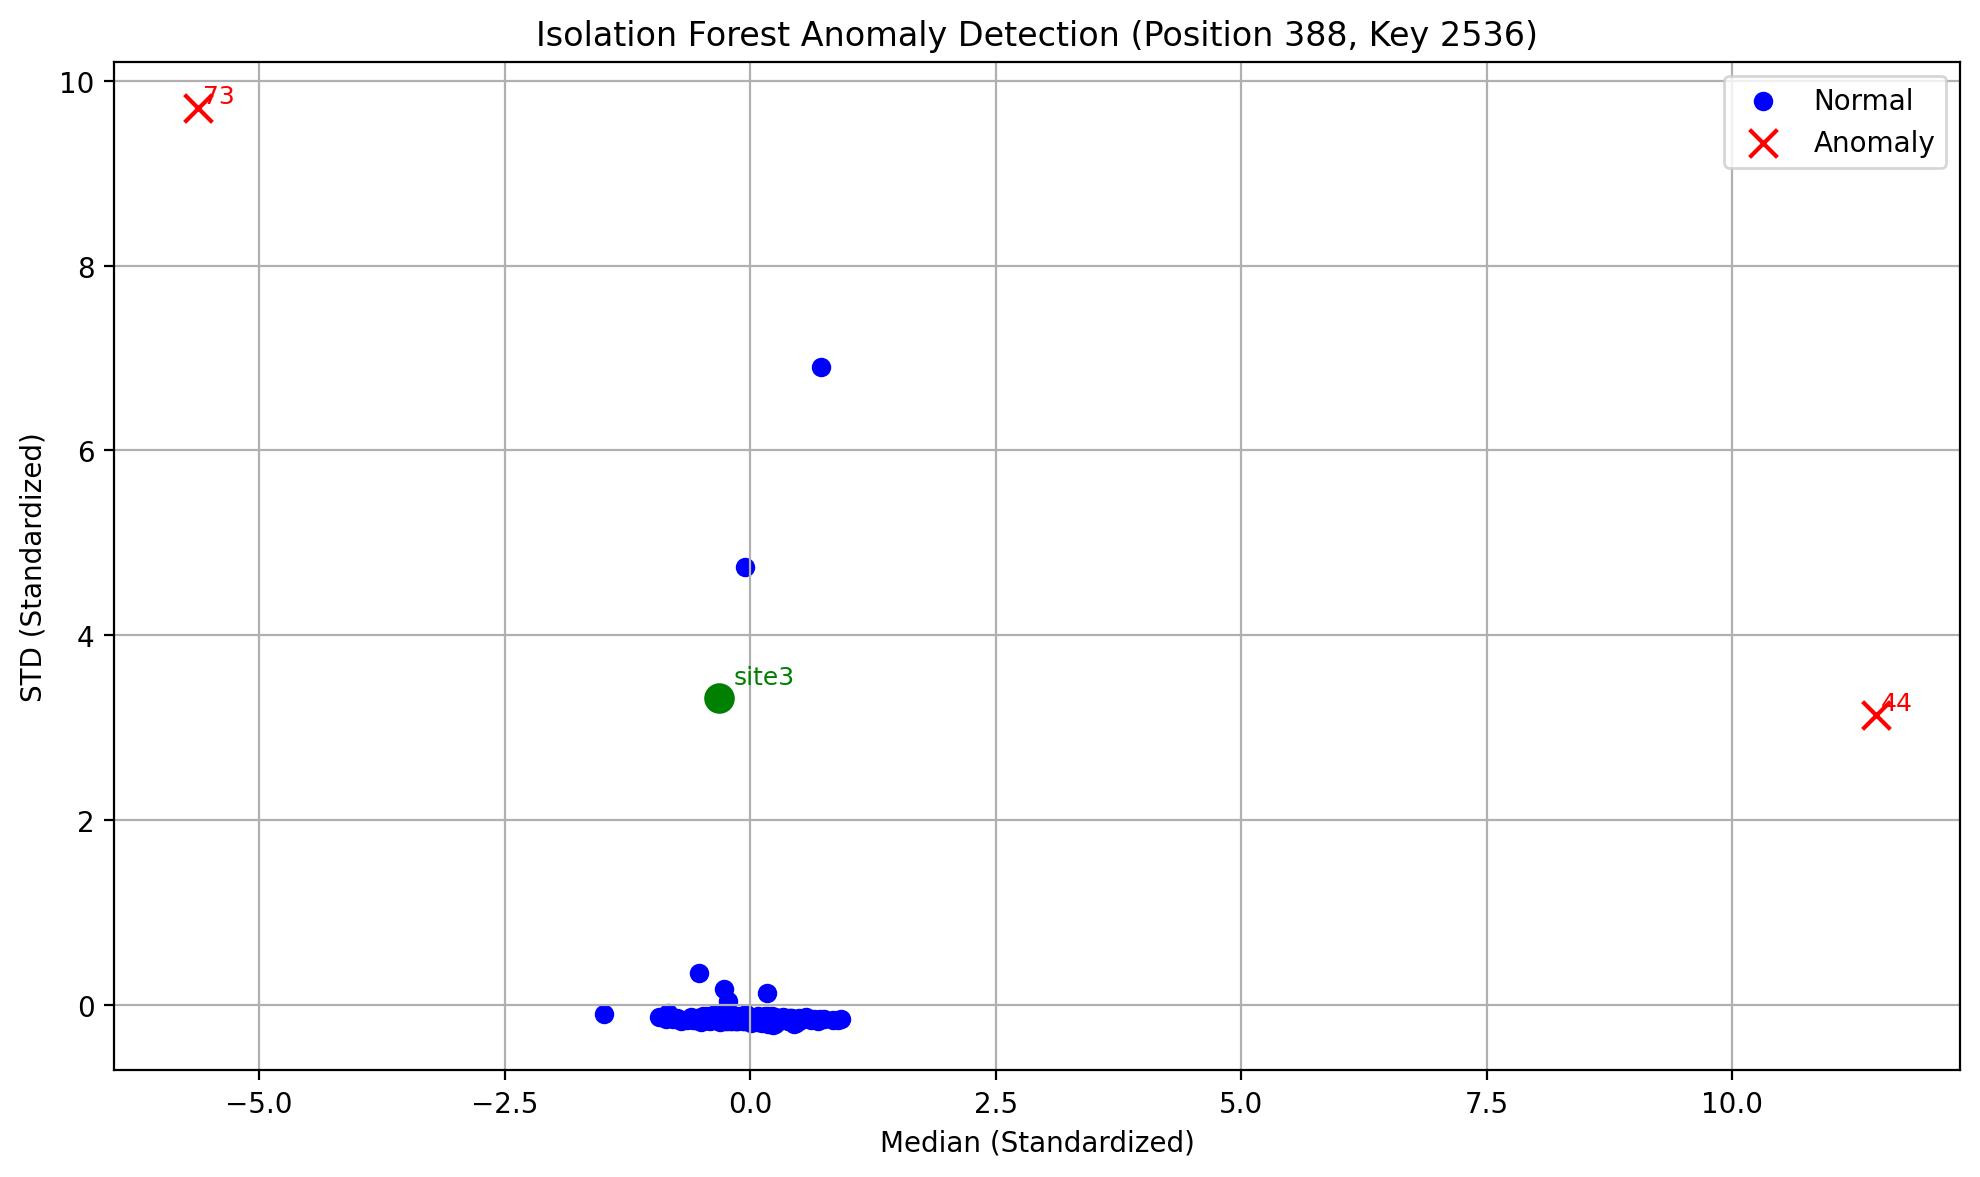

Anomalous sites detected for Position 388, Key 2536:
[44, 73]


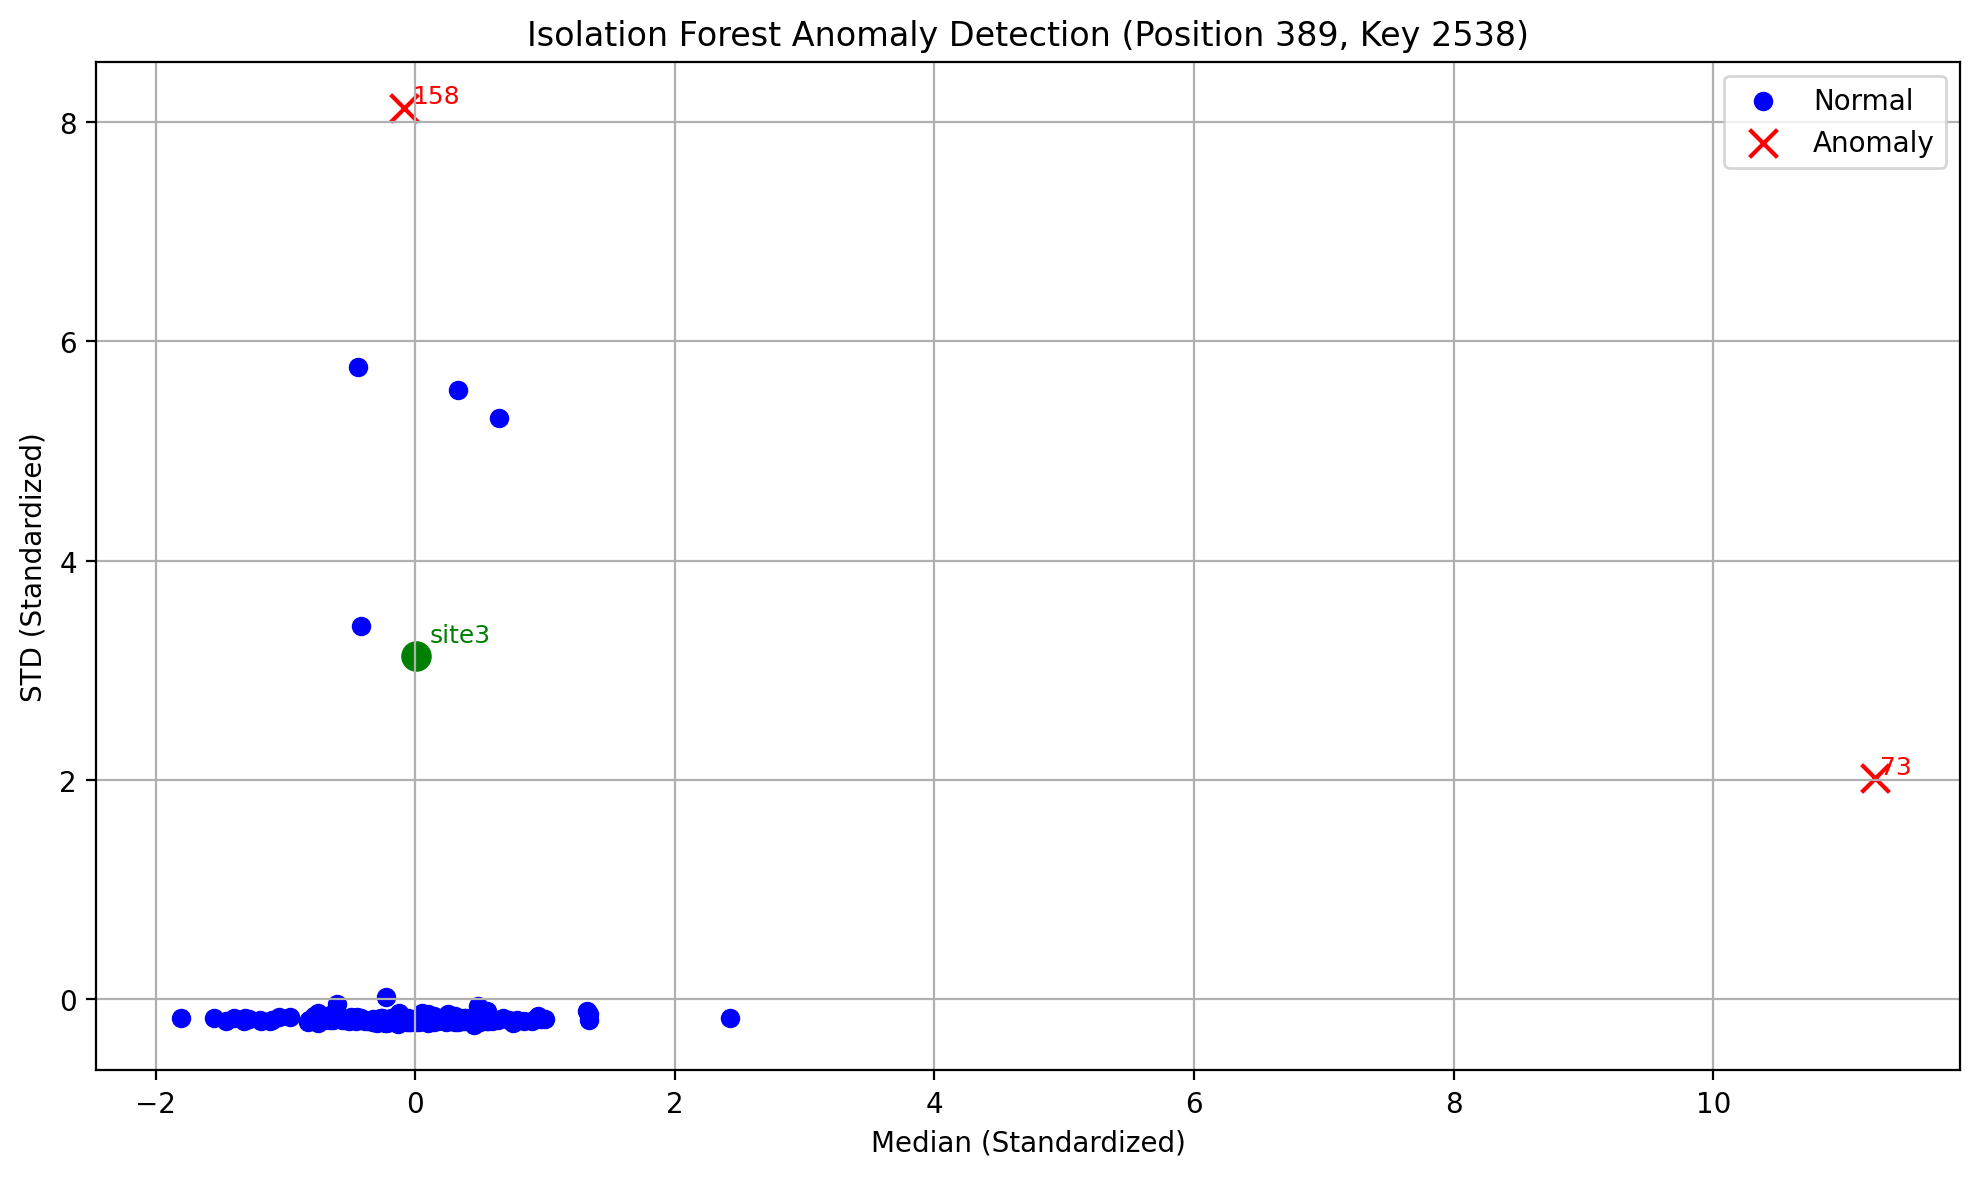

Anomalous sites detected for Position 389, Key 2538:
[73, 158]


In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Define the positions and corresponding dictionary keys with non-empty 'missed'
indices_with_missed = [
    (102, 179),
    (104, 183),
    (106, 187),
    (236, 371),
    (305, 865),
    (374, 2469),
    (378, 2495),
    (382, 2519),
    (386, 2534),
    (388, 2536),
    (389, 2538)
]

# Loop through each position and visualize
for position, key in indices_with_missed:
    param_med = z_med.iloc[position, :]
    param_std = z_std.iloc[position, :]
    data = pd.concat([param_med, param_std], axis=1)
    data.columns = ['med', 'std']

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.0065, random_state=42)
    data['anomaly'] = iso_forest.fit_predict(data[['med', 'std']])

    # Plotting
    plt.figure(figsize=(10, 6))
    normal = data[data['anomaly'] == 1]
    anomalies = data[data['anomaly'] == -1]

    plt.scatter(normal['med'], normal['std'], c='blue', label='Normal')
    plt.scatter(anomalies['med'], anomalies['std'], c='red', label='Anomaly', marker='x', s=100)

    # Annotate anomalies with site names
    texts = []
    for site, row in anomalies.iterrows():
        texts.append(plt.text(row['med'], row['std'], str(site), fontsize=9, color='red'))
    adjust_text(texts)

    # Annotate missed sites in green
    missed_sites = comparison_summary[key]['missed']
    for missed_site in missed_sites:
        if str(missed_site) in data.index.astype(str):
            row = data.loc[int(missed_site)]
            plt.scatter(row['med'], row['std'], c='green', marker='o', s=100)
            plt.annotate(f'site{missed_site}', (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')

    plt.xlabel('Median (Standardized)')
    plt.ylabel('STD (Standardized)')
    plt.title(f'Isolation Forest Anomaly Detection (Key {key})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print anomalous site names
    print(f"Anomalous sites detected for Key {key}:")
    print(anomalies.index.tolist())



          med       std
1   -0.048411 -0.603927
2    0.058544 -0.615086
3    0.486366  0.547108
4    0.058544 -0.277321
5   -0.155366 -0.031557
..        ...       ...
188 -0.155366 -0.653321
189  0.272455 -0.524446
190  0.058544 -1.153532
191  0.058544 -0.321670
192  0.058544 -0.707774

[192 rows x 2 columns]


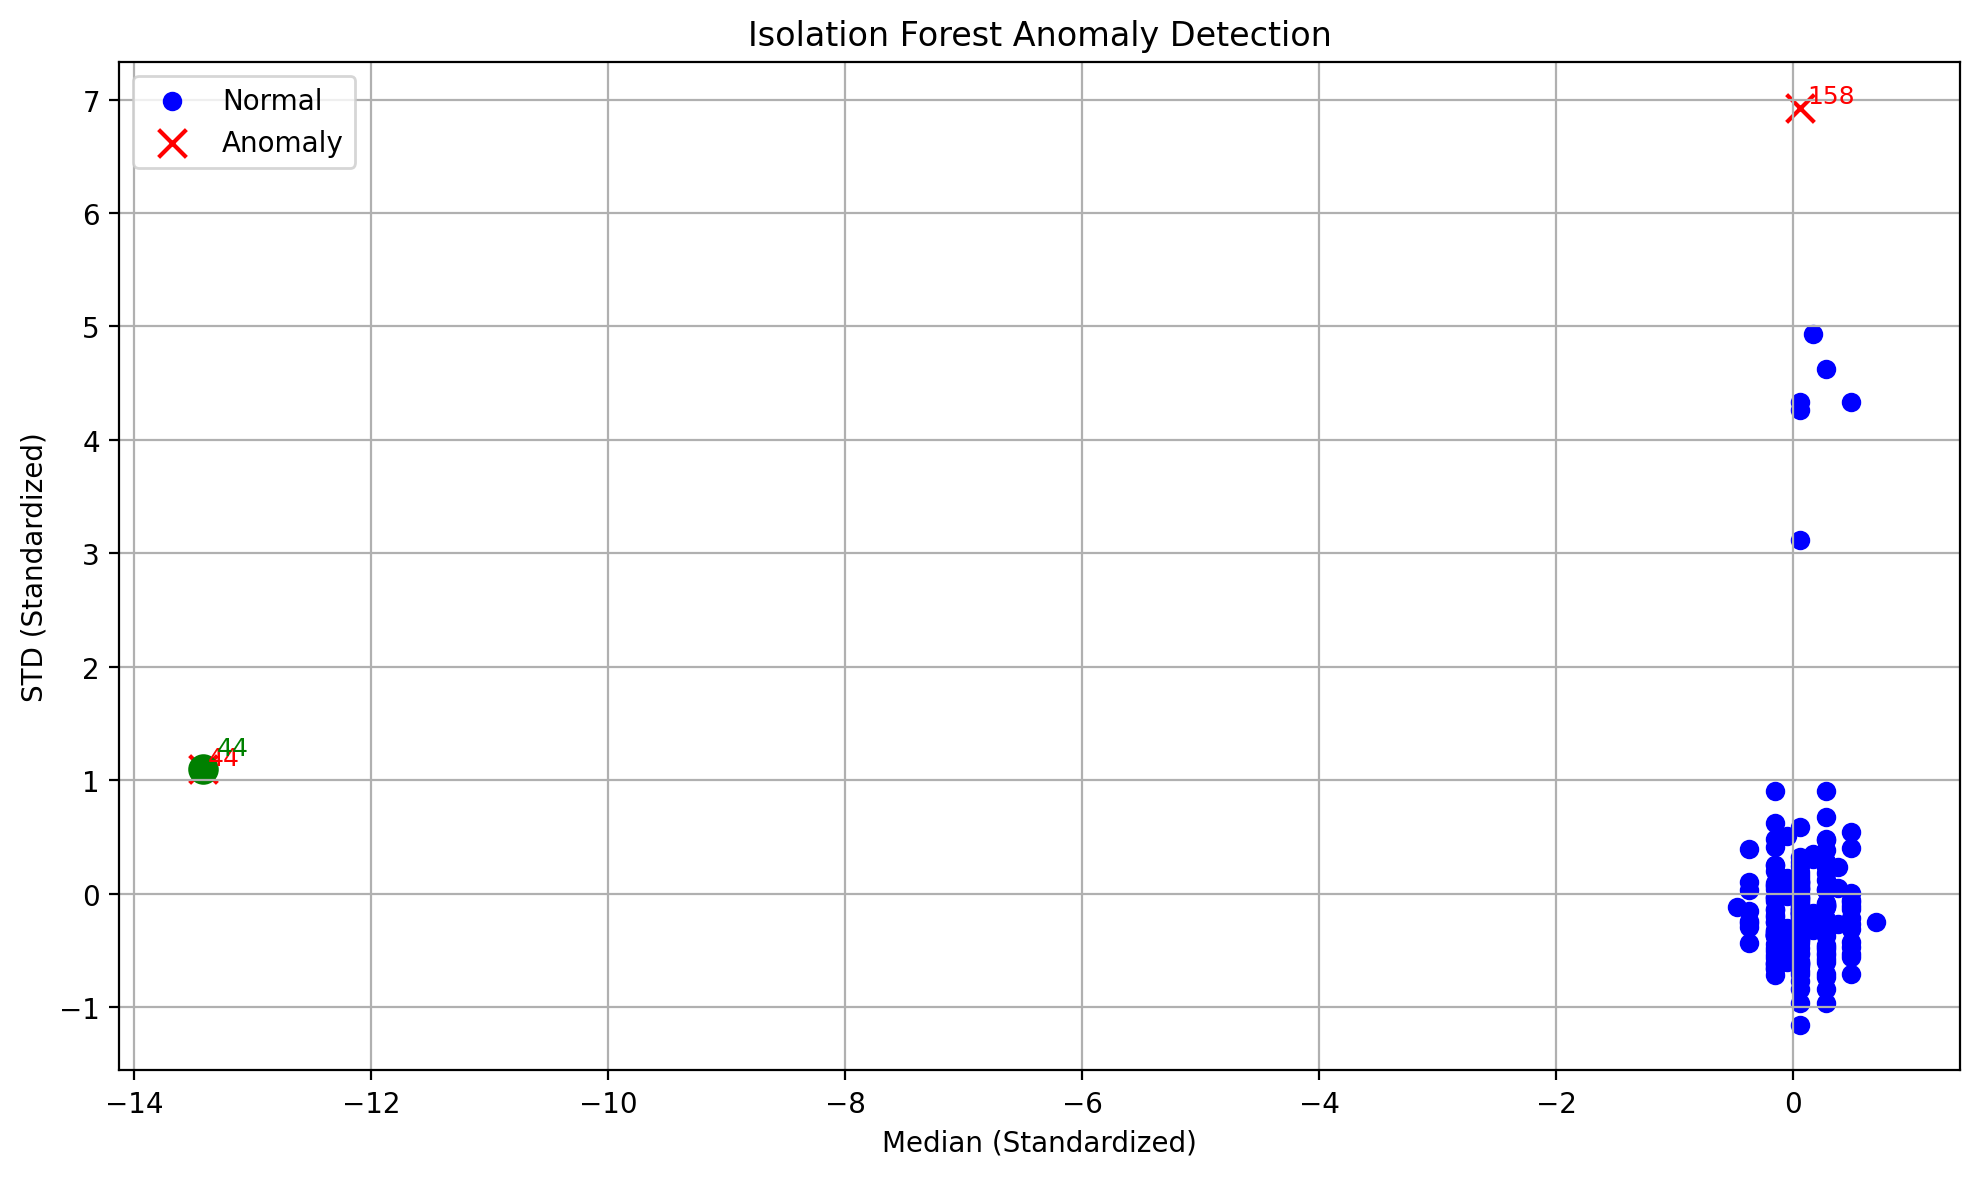

Anomalous sites detected:
[44, 158]


In [91]:
# Analyzing Individual Cases

param_1_med = z_med.iloc[24, :]
param_1_std = z_std.iloc[24, :]
data = pd.concat([param_1_med, param_1_std], axis=1)
data.columns = ['med', 'std']
print(data)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.0065, random_state=42)
data['anomaly'] = iso_forest.fit_predict(data[['med', 'std']])

# Plotting
plt.figure(figsize=(10, 6))
normal = data[data['anomaly'] == 1]
anomalies = data[data['anomaly'] == -1]

plt.scatter(normal['med'], normal['std'], c='blue', label='Normal')
plt.scatter(anomalies['med'], anomalies['std'], c='red', label='Anomaly', marker='x', s=100)

# Annotate anomalies with site names
texts = []
for site, row in anomalies.iterrows():
    texts.append(plt.text(row['med'], row['std'], site, fontsize=9, color='red'))
adjust_text(texts)


# Annotate site182 if it exists in the data
if 44 in data.index:
    row = data.loc[44]
    plt.scatter(row['med'], row['std'], c='green', marker='o', s=100)
    plt.annotate('44', (row['med'], row['std']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9, color='green')


plt.xlabel('Median (Standardized)')
plt.ylabel('STD (Standardized)')
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print anomalous site names
print("Anomalous sites detected:")
print(anomalies.index.tolist())

In [85]:
# Seems to me like standard deviation does not have that big of an impact on decision than median
# I want code where the plot title will include which row it is on the spreadsheet
# I also want some mechanism to compare our predicted to engineer classification
# Also examine what it looks like on Exensio

# Dont fill na with 0 (keep as na)
# 1. Generate own median and standard deviation values directly from EY
# 2. Retrain binary classification models again with own document
# Note: if value exists, then valid. If value n/a, the don't consider

# Use Gauge R and R first
